In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import math
from scipy.stats import wasserstein_distance
import multiprocessing as mp
import time

In [2]:
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'CUDA current: {torch.cuda.current_device()}')

CUDA available: True
CUDA current: 0


In [3]:
class dataGenerator():
    def __init__(self, batchsize, bins):
        self.batchsize=batchsize
        self.bins=bins
    
    def datagen(self):
        histograms = np.zeros((self.batchsize, 30), dtype=np.int64)
        means = np.zeros(self.batchsize)
        sigmas = np.zeros(self.batchsize)
        total_counts = np.zeros(self.batchsize)
        for i in range(self.batchsize):
            nsamples = np.random.randint(0,10000)
            mu = np.random.uniform(0.2,0.4)
            sigma = np.random.uniform(0.1, 0.3)

            samples = np.random.normal(mu, sigma, nsamples)

            hist,_ = np.histogram(samples, bins=self.bins, range=(0,1))
            histograms[i,:] = hist
            means[i] = mu
            sigmas[i] = sigma
            total_counts[i] = hist.sum()

        return histograms, means, sigmas, total_counts

In [80]:
data = dataGenerator(1500000,30)

In [81]:
hist, means, sigmas, counts = data.datagen()

In [82]:
means = np.array(means)
sigmas = np.array(sigmas)
counts = np.array(counts)
conds = np.column_stack([means, sigmas, counts])

print(len(hist))
print

1500000


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [83]:
hist_train, hist_test, conds_train, conds_test = train_test_split(hist,conds, test_size=0.2, random_state=42)

hist_test = torch.tensor(hist_test, dtype=torch.float32)
hist_train = torch.tensor(hist_train, dtype=torch.float32)

conds_test = torch.tensor(conds_test, dtype=torch.float32)
conds_train = torch.tensor(conds_train, dtype=torch.float32)

In [84]:
class Encoder(torch.nn.Module):
    def __init__(self, cond_dim: int, hidden_dim: int, latent_dim=16, input_dim=30):
        super().__init__()
        self.input_dim=input_dim
        self.cond_dim=cond_dim
        self.latent_dim=latent_dim
        self.total_dim=self.input_dim + self.cond_dim
        self.Mu = torch.nn.Sequential(
            torch.nn.Linear(self.total_dim,hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim,hidden_dim * 2),
            torch.nn.BatchNorm1d(hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 2, hidden_dim * 4),
            torch.nn.BatchNorm1d(hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 4, hidden_dim * 2),
            torch.nn.BatchNorm1d(hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim, self.latent_dim)
        )

        ## This here is actually the log(sigma^2) measure ##
        self.log_Var = torch.nn.Sequential(
            torch.nn.Linear(self.total_dim,hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim,hidden_dim * 2),
            torch.nn.BatchNorm1d(hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 2, hidden_dim * 4),
            torch.nn.BatchNorm1d(hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 4, hidden_dim * 2),
            torch.nn.BatchNorm1d(hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim, self.latent_dim)
        )


    def forward(self, input_vec, cond_vec):

        x = torch.cat([input_vec, cond_vec], dim=1)

        mu = self.Mu(x)
        log_Var = self.log_Var(x)

        sigma = torch.exp(0.5 * log_Var)
        
        batchsize = mu.size(0)
        epsilon = torch.randn(batchsize, self.latent_dim, device=mu.device)

        latent_vec = mu + epsilon * sigma

        return latent_vec, mu, log_Var

In [85]:
class Decoder(torch.nn.Module):
    def __init__(self, cond_dim, hidden_dim, latent_dim=16, output_dim=30):
        super().__init__()
        self.latent_dim=latent_dim
        self.cond_dim=cond_dim
        self.output_dim=output_dim
        self.hiden_dim=hidden_dim

        self.total_dim=self.latent_dim+self.cond_dim

        self.Model = torch.nn.Sequential(
            torch.nn.Linear(self.total_dim,hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim,hidden_dim * 2),
            torch.nn.BatchNorm1d(hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 2, hidden_dim * 4),
            torch.nn.BatchNorm1d(hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 4, hidden_dim * 2),
            torch.nn.BatchNorm1d(hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim, self.output_dim),
            torch.nn.Softplus()

        )
    def forward(self, latent_vec, cond_vec):

        x = torch.cat([latent_vec, cond_vec], dim=1)

        return self.Model(x)    

In [91]:
class HistGenerator:
    def __init__(self, x_test, x_train, t_test, t_train, cond_dim, bins = 30, hidden_dim = 64, latent_dim=16, batch_size=32):
        self.cond_dim = cond_dim
        self.hidden_dim = hidden_dim
        self.latent_dim=latent_dim
        self.x_test=x_test
        self.x_train=x_train
        self.t_test=t_test
        self.t_train=t_train
        self.bins=bins
        self.batch_size=batch_size

        self.encoder = Encoder(self.cond_dim, self.hidden_dim, self.latent_dim, self.bins)
        self.decoder = Decoder(self.cond_dim, self.hidden_dim, self.latent_dim, self.bins)

        params = list(self.encoder.parameters()) + list(self.decoder.parameters())

        self.model_optim = torch.optim.Adam(params, lr=0.0001)

        self.training_losses = []
        self.test_losses = []
        self.reconstruction_losses = []
        self.KL_losses = []

        train_dataset = torch.utils.data.TensorDataset(self.x_train, self.t_train)
        test_dataset = torch.utils.data.TensorDataset(self.x_test, self.t_test)

        self.train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = self.batch_size, 
            shuffle=True,
            num_workers=0,
            pin_memory=True,
        )

        self.test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size = self.batch_size * 2, 
            shuffle=True,
            num_workers=0,
            pin_memory=True,
        )

        self.poission_loss = torch.nn.PoissonNLLLoss(reduction='mean', log_input=False, full=False)

        self.device = torch.device('cuda')

        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
    
    def check_gpu_bottleneck(self, num_batches=50):
        """
        Run this BEFORE full training to diagnose if you need workers.
        Tests current dataloader setup and reports GPU utilization.
        """
        import subprocess
        import time
        
        print("=" * 60)
        print("DIAGNOSTIC: Checking for bottlenecks...")
        print("=" * 60)
        
        # Start monitoring GPU
        gpu_process = subprocess.Popen(
            ['nvidia-smi', 'dmon', '-s', 'u', '-c', '999'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        
        time.sleep(1)  # Let monitoring start
        
        # Time some training batches
        self.encoder.train()
        self.decoder.train()
        
        batch_times = []
        data_times = []
        compute_times = []
        
        print(f"\nTesting {num_batches} batches...")
        
        start_total = time.time()
        batch_start = time.time()
        
        for i, (real_data, conditions) in enumerate(self.train_loader):
            if i >= num_batches:
                break
            
            # Time data loading
            data_time = time.time() - batch_start
            data_times.append(data_time)
            
            # Time computation
            compute_start = time.time()
            real_data = real_data.to(self.device, non_blocking=True)
            conditions = conditions.to(self.device, non_blocking=True)
            
            self.model_optim.zero_grad()
            latent_vec, mu, log_Var = self.encoder(real_data, conditions)
            reconstructed_x = self.decoder(latent_vec, conditions)
            total_loss, _, _ = self.cvae_loss(real_data, reconstructed_x, mu, log_Var)
            total_loss.backward()
            self.model_optim.step()
            
            compute_time = time.time() - compute_start
            compute_times.append(compute_time)
            
            batch_time = time.time() - batch_start
            batch_times.append(batch_time)
            batch_start = time.time()
        
        total_time = time.time() - start_total
        
        # Stop GPU monitoring
        gpu_process.terminate()
        time.sleep(0.5)
        
        # Get GPU utilization
        gpu_result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
            capture_output=True, text=True
        )
        
        # Calculate statistics
        avg_data = sum(data_times) / len(data_times) * 1000
        avg_compute = sum(compute_times) / len(compute_times) * 1000
        avg_batch = sum(batch_times) / len(batch_times) * 1000
        
        data_percent = (sum(data_times) / total_time) * 100
        compute_percent = (sum(compute_times) / total_time) * 100
        
        # Print results
        print("\n" + "=" * 60)
        print("RESULTS:")
        print("=" * 60)
        print(f"Average per batch:")
        print(f"  Data loading:  {avg_data:6.2f} ms ({data_percent:5.1f}% of time)")
        print(f"  Computation:   {avg_compute:6.2f} ms ({compute_percent:5.1f}% of time)")
        print(f"  Total batch:   {avg_batch:6.2f} ms")
        print(f"\nThroughput: {num_batches/total_time:.1f} batches/sec")
        
        try:
            gpu_util = int(gpu_result.stdout.strip())
            print(f"GPU Utilization: {gpu_util}%")
        except:
            gpu_util = None
            print("GPU Utilization: Could not measure")
        
        # Diagnosis
        print("\n" + "=" * 60)
        print("DIAGNOSIS:")
        print("=" * 60)
        
        if compute_percent > 80:
            print(" GPU is the bottleneck (computation takes >80% of time)")
            print("   → Workers will NOT help significantly")
            print("   → Current setup is optimal")
        elif data_percent > 30:
            print("  Data loading is slow (>30% of time)")
            print("   → Try adding workers: num_workers=2 or 4")
            print("   → Current num_workers:", self.train_loader.num_workers)
        else:
            print("✓ Balanced - no major bottleneck")
        
        if gpu_util and gpu_util > 85:
            print("\nGPU highly utilized (>85%)")
            print("   → No need for workers")
        elif gpu_util and gpu_util < 60:
            print(f"\n Low GPU utilization ({gpu_util}%)")
            print("   → GPU is waiting for data")
            print("   → Add workers or check for other issues")
        
        print("=" * 60)
        
        return {
            'avg_data_ms': avg_data,
            'avg_compute_ms': avg_compute,
            'data_percent': data_percent,
            'compute_percent': compute_percent,
            'gpu_util': gpu_util
        }

    def print_training_info(self):
        """Print information about training scale"""
        num_train_samples = len(self.x_train)
        num_test_samples = len(self.x_test)
        batches_per_epoch = len(self.train_loader)
        
        print("=" * 60)
        print("TRAINING SCALE:")
        print("=" * 60)
        print(f"Training samples: {num_train_samples:,}")
        print(f"Test samples: {num_test_samples:,}")
        print(f"Batch size: {self.batch_size}")
        print(f"Batches per epoch: {batches_per_epoch:,}")
        print(f"\nEstimated time per epoch:")
        print(f"  At 6.6ms/batch: {batches_per_epoch * 0.0066:.2f} seconds")
        print(f"  At 150 batches/sec: {batches_per_epoch / 150:.2f} seconds")
        print("=" * 60)
    
    
    def cvae_loss(self, x, reconstructed_x, mu, log_Var):
        reconstruction_loss = self.poission_loss(x,reconstructed_x)
        KL_loss = -0.5 * torch.sum(1 + log_Var - mu.pow(2) - log_Var.exp(), dim=1)
        KL_loss = torch.mean(KL_loss)

        cvaeloss = reconstruction_loss+KL_loss
        return cvaeloss, reconstruction_loss, KL_loss
        
        
    def train_step(self, x_train, t_train):
        x_train = x_train.to(self.device, non_blocking=True)
        t_train = t_train.to(self.device, non_blocking=True)
        
        self.model_optim.zero_grad()

        latent_vec, mu, log_Var = self.encoder(x_train, t_train)
        reconstructed_x = self.decoder(latent_vec, t_train)

        total_loss, reconstruction_loss, KL_loss = self.cvae_loss(x_train, reconstructed_x, mu, log_Var)

        total_loss.backward()
        self.model_optim.step()

        return total_loss.item(), reconstruction_loss.item(), KL_loss.item()

    def evaluate(self):
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            for x,t in self.test_loader:
                x = x.to(self.device, non_blocking=True)
                t = t.to(self.device, non_blocking=True)

                z,mu,log_Var = self.encoder(x,t)
                reconstructed_x = self.decoder(z,t)

                batch_loss, batch_recon, batch_kl = self.cvae_loss(x,reconstructed_x,mu,log_Var)
                self.test_losses.append(batch_loss.item())

                fake_histograms_np = reconstructed_x.cpu().numpy()
                true_histograms_np = x.cpu().numpy()
                
                EMD = np.zeros(x.size(0))
                for i in range(x.size(0)):
                    # This requires an external implementation of wasserstein_distance (e.g., scipy.stats)
                    EMD[i] = wasserstein_distance(
                        fake_histograms_np[i], 
                        true_histograms_np[i]
                    )
                emd_score = EMD.mean()
                

        metrics = {
            'Total Test Loss': batch_loss.item(),
            'EMD Score': emd_score
        }

        self.encoder.train()
        self.decoder.train()      

        return metrics
        

    def training_loop(self, epochs, print_every=100, eval_every=50):
        print(f"Training the network for {epochs} epochs")

        for epoch in range(epochs):
            epoch_total_losses = []
            epoch_recon_losses = []
            epoch_kl_losses = []
            for real_data, conditions in self.train_loader: 
                total_loss, reconstruction_loss, kl_loss = self.train_step(real_data,conditions)
                self.training_losses.append(total_loss)
                self.reconstruction_losses.append(reconstruction_loss)
                self.KL_losses.append(kl_loss)

                epoch_total_losses.append(total_loss)
                epoch_recon_losses.append(reconstruction_loss)
                epoch_kl_losses.append(kl_loss)

            
            avg_total_loss = sum(epoch_total_losses) / len(epoch_total_losses)
            avg_recon_loss = sum(epoch_recon_losses) / len(epoch_recon_losses)
            avg_kl_loss = sum(epoch_kl_losses) / len(epoch_kl_losses)

            self.training_losses.append(avg_total_loss)
            self.reconstruction_losses.append(avg_recon_loss)
            self.KL_losses.append(avg_kl_loss)
            
            if (epoch + 1) % print_every == 0:
                print(f"Epoch [{epoch + 1}/{epochs}] | Training Loss: {avg_total_loss:.4f} | Reconstruction Loss: {avg_recon_loss:.4f} | KL Loss: {avg_kl_loss:.4f}")
            if (epoch+1) % eval_every == 0:
                metrics = self.evaluate()
                print(f"\n--- Test Set Evaluation (Epoch {epoch+1}) ---")
                print(f"  Test Losses: {metrics['Total Test Loss']:.3f}")
                print(f"  EMD Score: {metrics['EMD Score']:.3f}")
    

        
    def Hist_generator(self, input_cond_vec):
        self.decoder.eval()

        with torch.no_grad():
            if isinstance(input_cond_vec, np.ndarray):
                input_cond_vec = torch.FloatTensor(input_cond_vec)
            input_cond_vec = input_cond_vec.to(self.device)    
            latent_vec = torch.randn(input_cond_vec.size(0), self.latent_dim).to(self.device)

            generated_x = self.decoder(latent_vec, input_cond_vec)

            generated_x = generated_x.cpu()

        self.decoder.train()
        return generated_x.numpy()

    
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.training_losses, label='Training Loss', alpha=0.7)
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()  

        plt.figure(figsize=(10, 5))
        plt.plot(self.test_losses, label='Test Loss', alpha=0.7)
        plt.xlabel('Test Steps')
        plt.ylabel('Loss')
        plt.title('GAN Test Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show() 

    def plot_results(self, n = 4):
        indicies = torch.randint(0, len(self.x_test), (n,))
        
        conditions = self.t_test[indicies]
        fake_hist = self.Hist_generator(conditions)

        test_histograms = self.x_test[indicies]
        grid_size = int(math.ceil(math.sqrt(n)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize = (15,6))
        for i in range(n):
            row = i // grid_size
            col = i % grid_size
            ## Here real histograms are to be plotted ##
            axes[row, col].plot(range(self.bins), test_histograms[i], color = 'blue', alpha=0.7, label='Data')
            axes[row, col].plot(range(self.bins), fake_hist[i], color='red', alpha=0.7, label='Generated')
            axes[row, col].set_ylabel('Counts')
    
        plt.tight_layout()
        plt.legend()
        plt.show() 

In [92]:
genvae = HistGenerator(
    x_test=hist_test,
    x_train=hist_train, 
    t_test=conds_test,
    t_train=conds_train,
    cond_dim=3
)

results = genvae.check_gpu_bottleneck(num_batches=50)

DIAGNOSTIC: Checking for bottlenecks...

Testing 50 batches...

RESULTS:
Average per batch:
  Data loading:    1.13 ms ( 15.0% of time)
  Computation:     6.18 ms ( 82.0% of time)
  Total batch:     7.31 ms

Throughput: 132.8 batches/sec
GPU Utilization: 0%

DIAGNOSIS:
 GPU is the bottleneck (computation takes >80% of time)
   → Workers will NOT help significantly
   → Current setup is optimal


In [93]:
# Run this:
genvae.print_training_info()

TRAINING SCALE:
Training samples: 1,200,000
Test samples: 300,000
Batch size: 32
Batches per epoch: 37,500

Estimated time per epoch:
  At 6.6ms/batch: 247.50 seconds
  At 150 batches/sec: 250.00 seconds


In [94]:
genvae.training_loop(epochs=5, print_every=1, eval_every=2)
genvae.plot_loss()

Training the network for 5 epochs
Epoch [1/5] | Training Loss: inf | Reconstruction Loss: inf | KL Loss: 1.4391
Epoch [2/5] | Training Loss: inf | Reconstruction Loss: inf | KL Loss: 5.5098

--- Test Set Evaluation (Epoch 2) ---
  Test Losses: inf
  EMD Score: 3406.713


KeyboardInterrupt: 

In [ ]:
genvae.plot_results(n=16)

In [69]:
hist = genvae.Hist_generator(torch.tensor([[0,1,400], [1,2,800]]))

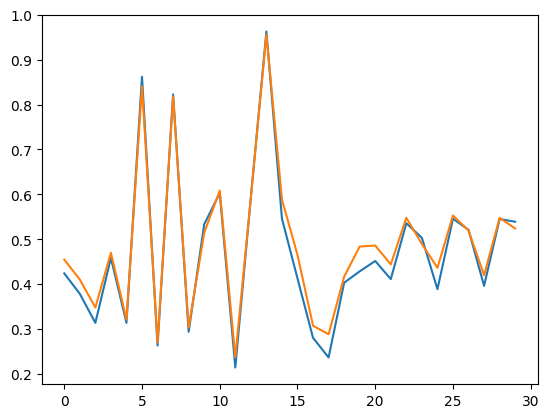

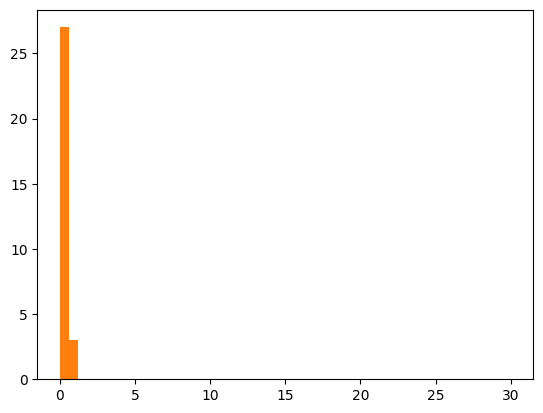

In [70]:
plt.plot(range(30), hist[0])
plt.plot(range(30), hist[1])
plt.show()

plt.hist(hist[0], bins=np.linspace(0,30))
plt.hist(hist[1], bins=np.linspace(0,30))
plt.show()